# Using Intel Software Development Tools For Maximizing Deep Learning Performance

## Step 1: Obtaining the Baseline Results

### Install Python and TensorFlow

First, we will use a traditional Python environment. At the beginning, you ran the script "devcon18", which installed a Conda environment with standard (PyPI) distribution of Python 3.6 and TensorFlow. If you wanted to reproduce this environment on your own system, you would run

Once installation is done, you should be able to use the tools in it by activating them. Let's check if this works. Run the cell below (highlight it and press Ctrl+Enter):

In [1]:
!conda env list

# conda environments:
#
test_env                 /home/u13849/.conda/envs/test_env
tf_1.6                   /home/u13849/.conda/envs/tf_1.6
tf_PyPI                  /home/u13849/.conda/envs/tf_PyPI
tf_intel                 /home/u13849/.conda/envs/tf_intel
root                  *  /glob/intel-python/versions/2018u2/intelpython3



If you see the environment "tf_PyPI" in the list, you are good to go. If you don't see it, you may need to wait a couple of minutes for the installation to finish in the background. Rerun the above cell in a minute.

### Train the human segmentation model inside the conda environment tf_PyPI:
- Standard python distribution
- Standard Tensorflow 1.7.0
- Read input data directly from desk and preprocess data on the fly, using tf.data API
- Batch size = 32
- Data format = NHWC

This is a snippet of the code in our application that reads and prepares the data that is fed into the training pipeline

Run the cell below to create a training script case1.py. It will train for 3 epochs with a batch size of 32.

In [28]:
%%writefile case1.py
#Case(1): standard Python distribution + standard tensorflow + raw_data
from train_model import train_model
model = train_model()
model.train(32, 3, subset='train', source='raw_data')

Overwriting case1.py


Now run the cell below that creates the job script. This script will later go into the cloud queue.

In [29]:
%%writefile job1
cd $PBS_O_WORKDIR
source activate tf_PyPI
mkdir results
python case1.py > results/log1.txt

# need an empty line at the end

Overwriting job1


Finally, submit the job to the queue:

In [30]:
#Submit the job to the queue
!qsub job1

81049.c009


While you wait:

### How to set up VTune and start profiling your application

We do not provide VTune on the DevCloud, but the instructor will explain the workflow of setting up a VTune project.

<img src="notebook_data/1-welcome.png" style='border:2px solid gray'>

------------------------------------------------------

<img src="notebook_data/2-createproject.png" style='border:2px solid gray'>

----------------------------------------------------

<img src="notebook_data/3-config-1.png" style='border:2px solid gray'>

-----------------------------------------------------

<img src="notebook_data/4-config-2.png" style='border:2px solid gray'>

------------------------------------------------------

### To get more details about how to get VTune Amplifier and how to start using it visit this link:
[Intel VTune Amplifier](https://software.intel.com/en-us/intel-vtune-amplifier-xe)

-------------

By now, our job has finished. How fast is the application running? To find out, check the log by running the cell below.

In [31]:
!cat results/log1.txt

Training time Epoch 0: 142.627877 sec
Training time Epoch 1: 131.484085 sec
Training time Epoch 2: 126.226914 sec


#### Your output result should be close to the following:

- Training time per Epoch: 180.5 sec
- Training time per Epoch: 121.6 sec
- Training time per Epoch: 125.2 sec

Is it good? What is the system busy with during training? To find out, we analyzed the training in VTune and the results are shown below.

### Observation 1:

According to VTune, an OpenCV module uses around 12% of the CPU time. This is suspicious: why would OpenCV be used during training?
![Vtune-amplifier results, Bottom-up](notebook_data/case1-bottom-up.png)
---------------------------------------------------------------------------------
---

## Step 2: Improve Data Input Pipeline
### Apply data serialization:
- To get rid of the OpenCV overhead, we will use a recommended TensorFlow technique
- Reading data directly from tfrecord using tf.data API
- The snippet below illustrates the new approach.

Run the cell below to create the training application file.

In [3]:
%%writefile case2.py
#Case(2): standard Python distribution + standard tensorflow + tfrecord
from train_model import train_model
model = train_model()
model.train(32, 3, subset='train', source='tfrecord')

Writing case2.py


Run the next cell to create the new job script.

In [23]:
%%writefile job2
cd $PBS_O_WORKDIR
source activate tf_PyPI
python case2.py > results/log2.txt

# need an empty line at the end

Overwriting job2


Finally, submit the job.

In [24]:
#Submit the job to the queue
!qsub job2

81048.c009


In [25]:
!qstat

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
80970.c009                 ...ub-singleuser u13849          00:00:16 R jupyterhub     
81048.c009                 job2             u13849                 0 R batch          


You may need to wait a few minutes for the job to finish. When it's done, view the results by running the next cell.

In [26]:
!cat results/log2.txt

2018-05-04 17:19:00.436094: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
/home/u13849/.conda/envs/tf_PyPI/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Training time Epoch 0: 35.551409 sec
Training time Epoch 1: 34.805032 sec
Training time Epoch 2: 35.047966 sec


#### Your output result should be close to the following:

- Training time per Epoch: 35.5 sec
- Training time per Epoch: 35.2 sec
- Training time per Epoch: 35 sec


### Observation 2:
#### VTune Bottom-up
<kdb>![Vtune-amplifier results, Bottom-up](notebook_data/case2-bottom-up.png)</kdb>
--------------------------------------------------------------------------------
---

Looks like it worked. OpenCV is no longer one of the top hotspots, and the time per epoch went down from 120 to 35 seconds — a lot!

So, is this a good performance for our application? We will find out. This time we will do it using the Intel software development tool Application Performance Snapshot. Compared to VTune, it gives you less information, but APS is much easier to use.

#### APS report
Again, the Intel DevCloud does not support APS, so we collected performance data on a different system. To run the analysis with APS, we just had to prepend the Python invocation command with "aps":

The result is shown below.

[![Case(2) APS report](notebook_data/aps-case2.png)](notebook_data/aps-case2.html)
---------------------------------------------------------------------------------

---

What is the most striking aspect of this report?
- Low floating-point unit utilization
- 99% of the floating point instructions are 256-bit vector instructions

### Vector Instructions

Intel architecture processors have not only multiple cores, but also parallelism inside each core in the form of vector instructions. They allow you to apply a stream of mathematical instructions to not one, but up to 16 floating-point numbers at once. 

![Array Vectorization](notebook_data/array-vectorization.png)
---------------------------------------------------------------
---

### Evolution of Vector Instructions

![Array Vectorization](notebook_data/intel-isa-evolution.png)

-----

Processors on the Intel AI DevCloud are Intel Xeon Gold 6128 CPUs supporting 512-bit AVX-512 vector instructions. See for yourself: run the cell below. So why are we using 256-bit instructions?

In [8]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                24
On-line CPU(s) list:   0-23
Thread(s) per core:    2
Core(s) per socket:    6
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 85
Model name:            Intel(R) Xeon(R) Gold 6128 CPU @ 3.40GHz
Stepping:              4
CPU MHz:               1199.997
CPU max MHz:           3700.0000
CPU min MHz:           1200.0000
BogoMIPS:              6800.00
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              1024K
L3 cache:              19712K
NUMA node0 CPU(s):     0-5,12-17
NUMA node1 CPU(s):     6-11,18-23
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xto

## Step 3: Use Intel-Optimized TensorFlow

The reason why our code uses 256-bit instructions is that our framework, TensorFlow, is not compiled to use AVX-512. Let's get Intel-optimized TensorFlow compiled with the Intel Math Kernel Library with AVX-512 support for DNN promitives.

You already installed it when you ran "devcon18" from the terminal. If you want to do it on your system later, you will have to execute the following commands.

### Now change the conda environment to tf_intel to start using Intel optimizations for Python and Tensorflow:
- Intel distribution of Python 3.6
- Intel optimized Tensorflow 1.4.0
- Reading data from tfrecord file
- Data_format = NHWC


Create the training application:

In [9]:
%%writefile case3.py
#Case(3): Intel Python distribution + Intel optimized Tensorflow + tfrecord
from train_model import train_model
model = train_model()
model.train(32, 3, subset='train', source='tfrecord')

Writing case3.py


Create the job script, this time using the Conda environment "tf_intel":

In [1]:
%%writefile job3
cd $PBS_O_WORKDIR
source activate tf_intel
python case3.py > results/log3.txt

# need an empty line at the end

Overwriting job3


Submit the job to the queue:

In [2]:
#Submit the job to the queue
!qsub job3

81041.c009


A few minutes later, check the result:

In [19]:
!cat results/log3.txt

Training time Epoch 0: 57.616630 sec
Training time Epoch 1: 55.723902 sec
Training time Epoch 2: 56.306462 sec


#### Your output result should be close to the following:

- Training time per Epoch: 56.3 sec
- Training time per Epoch: 55.2 sec
- Training time per Epoch: 55.4 sec

--------------

### Observation 3:

Oops! The training time increased from 35 to 55 seconds. What does that mean? We ran the above job through APS and found the following.

- Now 96.5% of the floating-point instructions are 512-bit vector instructions, which is what we wanted
- However, the total FPU utilization is still low
- Sever OpenMP Imbalance 71%
- Number of OpenMP threads is 288 - that's way too many for our 12-core server!
    

[![Case(3) APS report](notebook_data/aps-case3.png)](notebook_data/aps-case3.html)
---------------------------------------------------------------------------------
---

### Inter-op/Intra-op Parallelism

As APS report shows, out-of-the-box run with Intel-optimized tensorflow uses too many OpenMP threads. That is because the default parallel strategy is not optimal for this CPU. Fortunately, TensorFlow allows parallel strategy tuning by with inter_op/intra_op threads parameter.

![Inter/Intra](notebook_data/inter-intra.png)

----

## Step 4:
### Now start tuning environment variables based on the guidance of the previous APS report:
- To resolve the high OpenMP imbalance, set the Inter-op-threads=2 (equals to number of sockets) and the Intra-op-threads=12 (equals to number of physical cores, 6 cores/socket)
- Repeat the job submission process with this new version:

In [4]:
%%writefile case4.py
#Case(4): Intel Python distribution + Intel optimized Tensorflow whl + tfrecord
from train_model import train_model
model = train_model()
model.train(32, 3, subset='train', source='tfrecord', inter=2, intra=12)

Overwriting case4.py


In [5]:
%%writefile job4
cd $PBS_O_WORKDIR
source activate tf_intel
python case4.py > results/log4.txt

# need an empty line at the end

Overwriting job4


In [6]:
#Submit the job to the queue
!qsub job4

81042.c009


A few minutes later, check the result:

In [18]:
!cat results/log4.txt

Training time Epoch 0: 19.620872 sec
Training time Epoch 1: 18.516181 sec
Training time Epoch 2: 18.235737 sec


#### Your output result should be close to the following:

- Training time per Epoch: 19.6 sec
- Training time per Epoch: 18.2 sec
- Training time per Epoch: 18.5 sec

This looks very good. The best we had with standard TensorFlow (256-bit instructions) is 35 seconds per epoch. With Intel-optimized TensorFlow, we use AVX-512, and after tuning the parallel strategy, it gives us a speedup by almost 2x, finishing each epoch in just over 18 seconds.

----------

Is that good? Are we done?


### Observation 4:

- We ran the code through APS again, and the results are shown below
- OpenMP imbalance is now better, but we still can improve it more


[![Case(4) APS report](notebook_data/aps-case4.png)](notebook_data/aps-case4.html)
---------------------------------------------------------------------------------
---

### Thread Affinity

Because Intel-optimized TensorFlow uses MKL, its threading is implemented with OpenMP. You can often reduce OpenMP load imbalance by binding threads to physical cores (setting thread affinity).

![Affinity](notebook_data/affinity-compact.png)

----


## Step 5:
### More tuning for environment variables to reduce the openMP high imbalance
- Set KMP_AFFINITY=compact,1,granularity=fine

In [8]:
%%writefile case5.py
#Case(4): Intel Python distribution + Intel optimized Tensorflow whl + tfrecord
from train_model import train_model
model = train_model()
model.train(32, 3, subset='train', source='tfrecord', inter=2, intra=12)

Overwriting case5.py


In [9]:
%%writefile job5
cd $PBS_O_WORKDIR
source activate tf_intel
export KMP_AFFINITY=compact,1,granularity=fine
python case5.py > results/log5.txt

# need an empty line at the end

Overwriting job5


In [10]:
#Submit the job to the queue
!qsub job5

81043.c009


In a minute, check the results:

In [17]:
!cat results/log5.txt

Training time Epoch 0: 17.792870 sec
Training time Epoch 1: 16.634165 sec
Training time Epoch 2: 16.577362 sec


#### Your output result should be close to the following:

- Training time Epoch 0: 17 sec
- Training time Epoch 1: 16.51 sec
- Training time Epoch 2: 16.3 sec

From 18 seconds per epoch, the training time is now around 16 seconds, so it was an improvement.

---

### Observation 5:

- Setting Affinity significantly reduces the openMP imbalance to below the threshold value (10%), but we still have high serial time
- Also FPU increases to be 13 %, but it could be better
- We ran APS once more to see what might be the bottleneck of the application. The result is shown below.


[![Case(5) APS report](notebook_data/aps-case5.png)](notebook_data/aps-case5.html)
---------------------------------------------------------------------------------
---

Even though the metric "Serial Time" is not highlighted in red, it is quite high. One of the reasons that the serial time can be longer than needed is that the processor is busy with unnecessary tasks during the serial period. For example, it may be busy maintaining the machinery of OpenMP threads between parallel regions. Fortunately, OpenMP has a control knob for this as well.

### KMP_BLOCKTIME

This Intel OpenMP parameter controls the time the thread should wait after execution, before sleeping. The default is 200 milliseconds.

![BlockTime](notebook_data/kmp_blocktime.svg.png)

----

## Step 6: 
### Setting KMP_BLOCKTIME to resolve high serial time and low FPU

To minimize the thread machinery overhead in serial regions, we will reduce the block time to 2 ms. Run the job below to see the impact of this optimization.

In [12]:
%%writefile case6.py
#Case(4): Intel Python distribution + Intel optimized Tensorflow whl + tfrecord
from train_model import train_model
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
model = train_model()
model.train(32, 3, subset='train', source='tfrecord', inter=2, intra=12)

Overwriting case6.py


In [13]:
%%writefile job6
cd $PBS_O_WORKDIR
source activate tf_intel
export KMP_AFFINITY=compact,1,granularity=fine
export KMP_BLOCKTIME=2
python case6.py > results/log6.txt

# need an empty line at the end

Overwriting job6


In [14]:
#Submit the job to the queue
!qsub job6

81045.c009


In a minute, check the result:

In [16]:
!cat results/log6.txt

Training time Epoch 0: 14.743615 sec
Training time Epoch 1: 13.746014 sec
Training time Epoch 2: 13.719015 sec


#### Your output result should be close to the following:

- Training time Epoch 0: 14 sec
- Training time Epoch 1: 13.75 sec
- Training time Epoch 2: 13.74 sec

Another improvement: from 16 seconds per epoch to 14 seconds per epoch.

-----

### Observation 6:
- Now the FPU is 2x better (31%)
- Also the serial time is now less than 10% of the total elapsed time (8.75%)


[![Case(6) APS report](notebook_data/aps-case6.png)](notebook_data/aps-case6.html)
---------------------------------------------------------------------------------

## Summary
- The following chart is showing the performance improvement for all previous cases

![All cases](notebook_data/chart-1-c009.png)

- The chart below isolates the best performance obtained with standard TensorFlow (35 seconds per epoch) and the best timing with Intel-optimized TensorFlow (14 seconds per epoch).
![All cases](notebook_data/chart-2-c009.png)

-----

## More about Tensorflow Optimizations for Intel architecture

[TensorFlow* Optimizations for the Intel® Xeon® Scalable Processor](https://ai.intel.com/tensorflow-optimizations-intel-xeon-scalable-processor/#_ftn3)


[Intel Optimized TensorFlow* Installation Guide](https://software.intel.com/articles/intel-optimized-tensorflow-installation-guide)


[TensorFlow* Optimizations on Modern Intel® Architecture](https://software.intel.com/en-us/articles/tensorflow-optimizations-on-modern-intel-architecture)

[TensorFlow Performance Guide](https://www.tensorflow.org/performance/performance_guide)


-----


## What We Learned

- Intel Distribution for Python delivers significant performance gain in deep learning over the standard Python distribution
- Intel VTune Amplifier is useful for detecting the specific modules of the application that hold back the performance
- Intel Application Performance Snapshot is useful for detecting general issues with the application

Naturally, the preformance analysis tools and methods discussed here are not limited to deep learning or Python. They apply to C/C++/Fortran programming in other domains as well.

## Human Segmentation After Optimization
Now, after using VTune Amplifier and APS guidance to optimize our model, we ran the training process for 1000 epochs. It took 14000 seconds (4 hours). Compare it to the estimated training time without optimization, which would have been 36000 seconds (10 hours).

We saved the trained weights, so you don't have to wait for 4 hours to see how the model works. Run the next cell to analyze a random image from the validation dataset and compare the prediction of the model to the ground truth mask.

INFO:tensorflow:Restoring parameters from weights/NHWC_train_hs_val_1000.ckpt


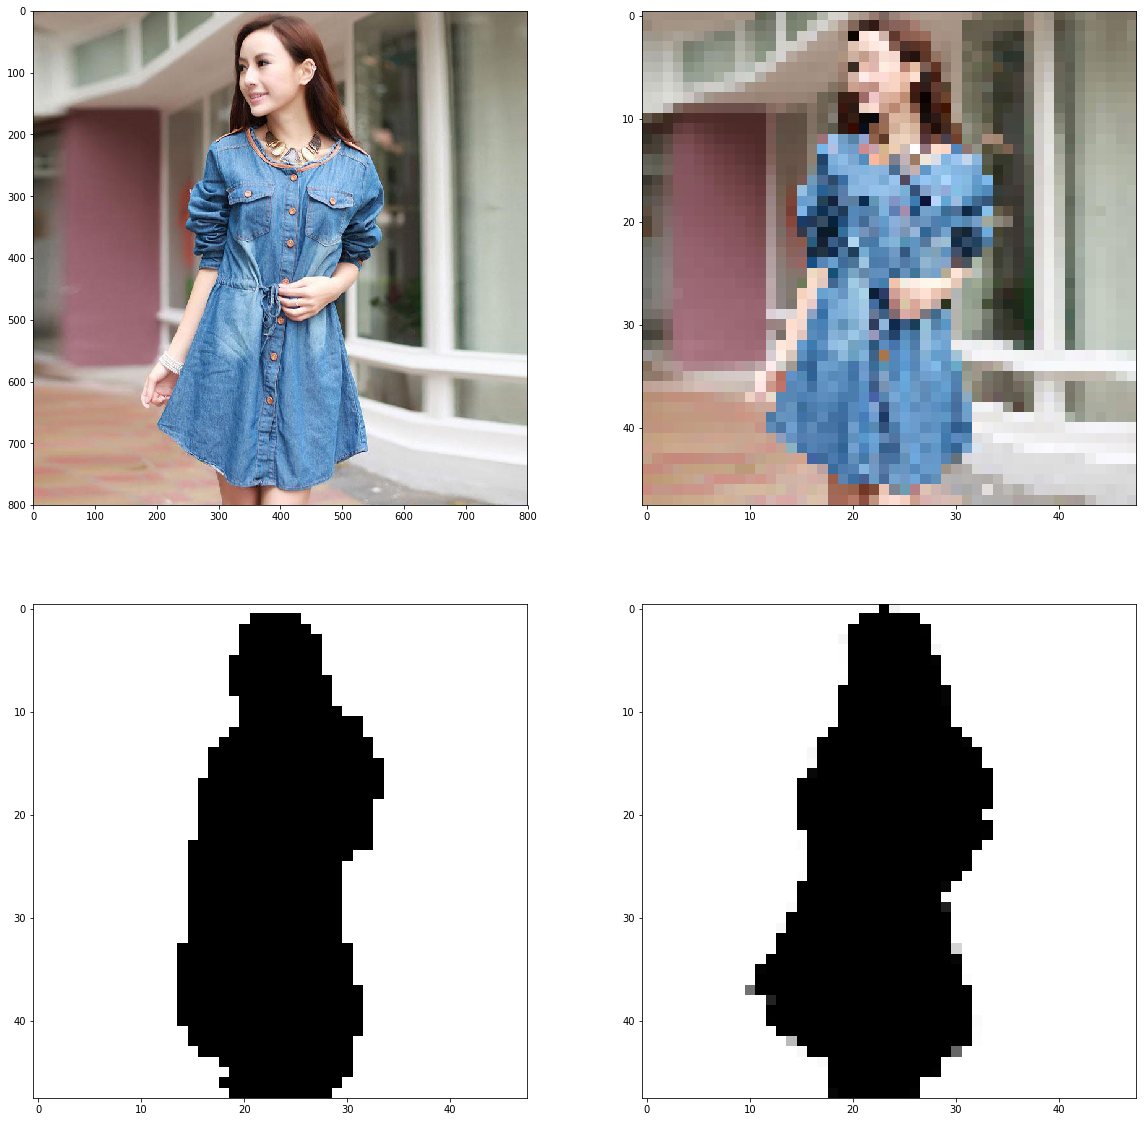

In [60]:
from inference import visualize
visualize("validate_dataset")

Displayed images are:
- Top left: original image
- Top right: original image resized (48, 48, 3)
- Bottom left: model output (48, 48)
- Bottom right: ground truth resized (48, 48)

## Try your own image
Why don't you try your own image now?
All what it needs is a person's image, it would provide better results if the image is of the following specs:

- Person standing with full length in the mid of the image
- Single person in the image
- Contrast exists between the background and the person in the image

Check the following image to have some idea about how should the image looks like:

<img src="notebook_data/example-image-2.jpg" width="200"  >

## Steps to try the human segmentation model by yourself:

- Upload an image with the previous specs:
    - From the Jyputer home page, click on Upload button on the top right to upload your image to the DevCloud
- Make sure to place it in the same directory as the notebook 
- Rename the image to "input-image.jpg"
- Run the next cell

In [ ]:
from inference import visualize
visualize("uploaded_image")